# DeepRLTennis: Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the Deep Reinforcement Learning Nanodegree program.

## 1. Start the Environment
We begin by importing the necessary packages. If the code cell below returns an error, please revisit the project instructions to double-check that you have installed Unity ML-Agents and NumPy.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment! Before running the code cell below, change the file_name parameter to match the location of the Unity environment that you downloaded.

```
- Mac: "path/to/Tennis.app"
- Windows (x86): "path/to/Tennis_Windows_x86/Tennis.exe"
- Windows (x86_64): "path/to/Tennis_Windows_x86_64/Tennis.exe"
- Linux (x86): "path/to/Tennis_Linux/Tennis.x86"
- Linux (x86_64): "path/to/Tennis_Linux/Tennis.x86_64"
- Linux (x86, headless): "path/to/Tennis_Linux_NoVis/Tennis.x86"
- Linux (x86_64, headless): "path/to/Tennis_Linux_NoVis/Tennis.x86_64"
```

For instance, if you are using a Mac, then you downloaded Tennis.app. If this file is in the same folder as the notebook, then the line below should appear as follows:

```
env = UnityEnvironment(file_name="Tennis.app")
```

In [ ]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis")

Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces¶

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment.


In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

## 3. Take Random Actions in the Environment¶
In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step. A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.


In [ ]:
env.close()


## 4. It's Your Turn!
Now it's your turn to train your own agent to solve the environment! When training the environment, set train_mode=True, so that the line for resetting the environment looks like the following:

```
env_info = env.reset(train_mode=True)[brain_name]
```

# Multi-Agent Deep Deterministic Plicy Gradient (MADDPG)
### 1. Import Necessary Packages

In [1]:
import random
import torch
import os
import numpy as np
import time
import matplotlib.pyplot as plt

from collections import deque

# Set plotting options
%matplotlib inline

# Hide Matplotlib deprecate warnings
import warnings
warnings.filterwarnings("ignore")

### 2. Instantiate Agent and Environment

In [2]:
from unityagents import UnityEnvironment
from ddpg_agent import Agent

import numpy as np

# Load a single agent of the environment
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis")

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# Path to save the mdoels and collect the Tensorboard logs
model_dir= os.getcwd()+"/model"
os.makedirs(model_dir, exist_ok=True)

In [4]:
# Reset the environment    
env_info = env.reset(train_mode=True)[brain_name]     

# number of agents
num_agents = len(env_info.agents)

# size of each action
ENV_ACTION_SIZE = brain.vector_action_space_size

# size of the state space 
states = env_info.vector_observations  # Array of states for all agents in teh enviroonments
ENV_STATE_SIZE = states.shape[1]

print('There are {} agents. Each observes a state with length: {} and act within an action space of length: {}'.format(states.shape[0], 
                                                                                                                       ENV_STATE_SIZE, 
                                                                                                                       ENV_ACTION_SIZE))

There are 2 agents. Each observes a state with length: 24 and act within an action space of length: 2


### 3. Train the model

In [5]:
from maddpg_agent import Maddpg
from hyperparameter import *

def train():
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    # Instantiate the MADDPG agents
    maddpg = Maddpg(ENV_STATE_SIZE, ENV_ACTION_SIZE, num_agents, SEED)

    # Monitor the score    
    scores_deque = deque(maxlen=100)
    all_scores = []
    moving = []
    
    # Intialize amplitude OU noise (will decay during training)
    noise = NOISE
    
    all_steps =0   # Monitor total number of steps performed
    
    # Training Loop
    for i_episode in range(EPISODES+1):  
             
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment  
        maddpg.reset()                                             # reset the agents 
            
        states = env_info.vector_observations                      # get the current state for each agent 
        scores = np.zeros(num_agents)                              # initialize the score (for each agent)

        for steps in range(STEPS):
            
            all_steps+=1

            actions = maddpg.act(states, noise)                    # retrieve actions to performe for each agents 
            noise *= NOISE_REDUCTION                               # Decrease action noise
            env_info = env.step(actions)[brain_name]               # send all actions to tne environment
            next_states = env_info.vector_observations             # get next state for each agent
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            
            # Save experience in replay memory, and use random sample from buffer to learn
            maddpg.step(states, actions, rewards, next_states, dones, i_episode)  

            scores += env_info.rewards                             # update the score (for each agent)
            states = next_states                                   # roll over states to next time step
            if np.any(dones):                                      # exit loop if episode finished
                break
        
        # Save scores and compute average score over last 100 episodes       
        episode_score  = np.max(scores)  # Consider the maximum score amongs all Agents
        all_scores.append(episode_score)
        scores_deque.append(episode_score)
        avg_score = np.mean(scores_deque)
        moving.append(avg_score)

        # Display statistics 
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpisode score (max over agents): {:.2f}'.format(i_episode, avg_score, episode_score), end="")
        if i_episode>0 and i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} (nb of total steps={}   noise={:.4f})'.format(i_episode, avg_score, all_steps, noise))
            maddpg.checkpoints()
        
        # Early stop
        if (i_episode > 99) and (avg_score >=0.5):
            print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score))
            maddpg.checkpoints()
            return all_scores, moving

    return all_scores, moving

In [7]:
scores, moving = train()

Episode 100	Average Score: 0.01 (nb of total steps=1610   noise=1.0000)
Episode 200	Average Score: 0.01 (nb of total steps=3298   noise=1.0000)
Episode 300	Average Score: 0.01 (nb of total steps=4932   noise=1.0000)
Episode 400	Average Score: 0.03 (nb of total steps=6887   noise=1.0000)
Episode 500	Average Score: 0.00 (nb of total steps=8408   noise=1.0000)
Episode 600	Average Score: 0.02 (nb of total steps=10131   noise=1.0000)
Episode 700	Average Score: 0.01 (nb of total steps=11732   noise=1.0000)
Episode 800	Average Score: 0.00 (nb of total steps=13152   noise=1.0000)
Episode 900	Average Score: 0.01 (nb of total steps=14867   noise=1.0000)
Episode 1000	Average Score: 0.01 (nb of total steps=16616   noise=1.0000)
Episode 1100	Average Score: 0.02 (nb of total steps=18415   noise=1.0000)
Episode 1200	Average Score: 0.03 (nb of total steps=20301   noise=1.0000)
Episode 1300	Average Score: 0.04 (nb of total steps=22611   noise=1.0000)
Episode 1400	Average Score: 0.05 (nb of total steps=

#### 3. Plot scores

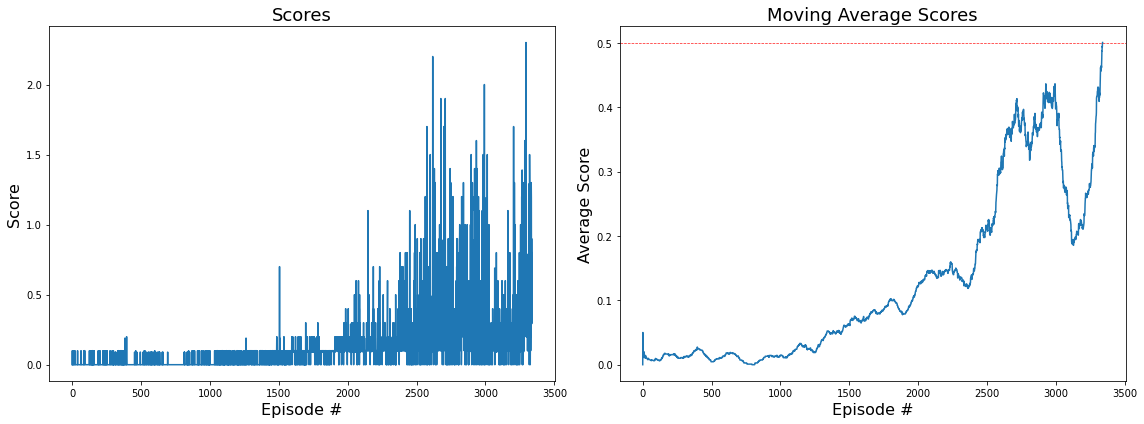

In [8]:
ls = 16
ts = 18

# plot the scores and moving average
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.plot(np.arange(len(scores)), scores)
ax1.set_ylabel('Score', fontsize=ls)
ax1.set_xlabel('Episode #', fontsize=ls)
ax1.set_title("Scores", fontsize=ts)

ax2.axhline(y=0.5, xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
ax2.plot(np.arange(len(moving)), moving)
ax2.set_ylabel('Average Score', fontsize=ls)
ax2.set_xlabel('Episode #', fontsize=ls)
ax2.set_title("Moving Average Scores", fontsize=ts)

fig.savefig('images/mmpg_result.jpg', format='jpg')
fig.tight_layout()

plt.show()

In [ ]:
env.close()